In [1]:
## Install the packages ###
devtools::install_github("sqjin/CellChat")
library(CellChat)
library("Seurat")
library("tidyverse")
library("dplyr")
library("circlize")
library("reticulate")
library("patchwork")

Skipping install of 'CellChat' from a github remote, the SHA1 (418b660a) has not changed since last install.
  Use `force = TRUE` to force installation

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: ggplot2

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to mak

In [2]:

## Step 1. reading the DSP data file
DSP_df <- read.table("/path_to_file/sample.txt", header=T, sep = "\t", check.names=T, row.names=1)
colnames(DSP_df) <- gsub(pattern="X", replacement="", colnames(DSP_df))
## Step 2. converting it to matrix, as cellchat require matrix
data.input <- as.matrix(DSP_df)
## Step 3. Reading Metadata file
DSP_df_meta <- read.table("path_to_file/sample_metadata.txt", header=T, sep = "\t", check.names=T, row.names=1) # row.names that matches with column of matrix should be in row, otherwise error erupts at later steps
meta <- DSP_df_meta ## Coercing it to metadata, necessary


In [3]:
## Step 4. Creating Cellchat object
cellchat <- createCellChat(object = data.input, meta = meta, group.by = "Segment_Cluster")

[1] "Create a CellChat object from a data matrix"
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  Distant.Liver Distant.Stroma TME.Tumor.Cluster.1 TME.Tumor.Cluster.2 TME.Tumor.Cluster.3 Tumor.Cluster.1 Tumor.Cluster.2 Tumor.Cluster.3 


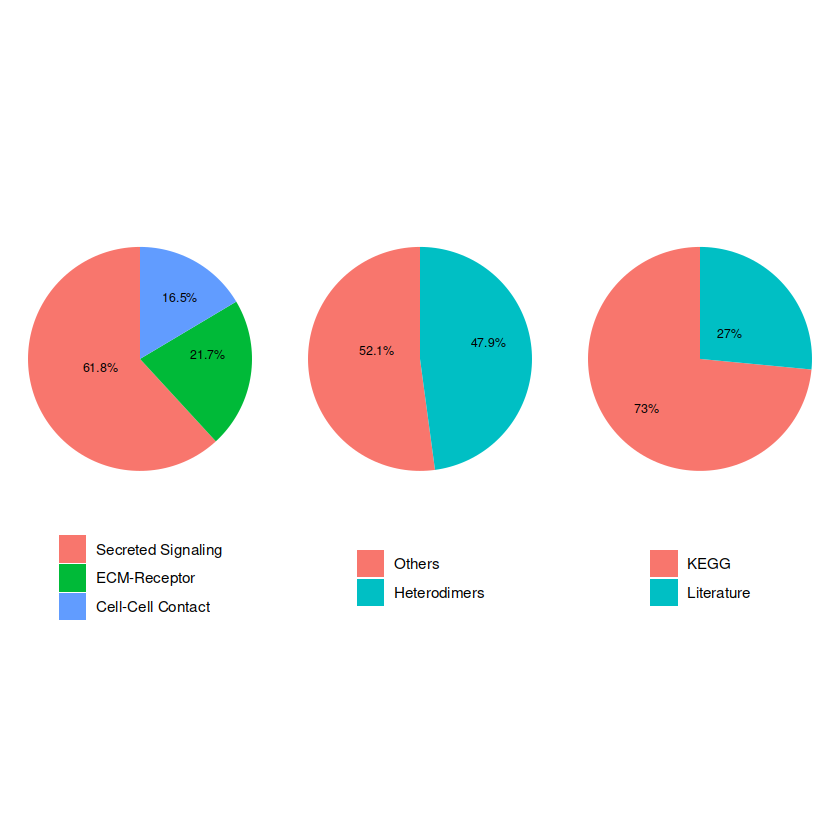

In [4]:
## Step 5. Uploading databases to cellchat
CellChatDB <- CellChatDB.human # use CellChatDB.mouse if running on mouse data
# see the database categories 
showDatabaseCategory(CellChatDB.human)
## Step 6. Set this database for cell-cell communication analysis
CellChatDB.use <- CellChatDB.human

In [5]:
# Step 7. subset the expression data of signaling genes for saving computation cost
cellchat@DB <- CellChatDB
cellchat <- subsetData(cellchat) # This step is necessary even if using the whole database
cellchat <- identifyOverExpressedGenes(cellchat)

In [6]:
# Step 8. Preprocessing the expression data for cell-cell communication analysis
cellchat <- identifyOverExpressedGenes(cellchat)
cellchat <- identifyOverExpressedInteractions(cellchat)
cellchat <- projectData(cellchat, PPI.human)

In [7]:
# Step 9. Infer the cell-cell communication at a signaling pathway level, 
# use TRUE, if want to use full dataset, otherwise set FALSE for use of projectedData
cellchat <- computeCommunProb(cellchat, raw.use = FALSE)

triMean is used for calculating the average gene expression per cell group. 
[1] ">>> Run CellChat on sc/snRNA-seq data <<< [2023-08-23 08:29:15]"
[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-08-23 08:37:34]"


In [92]:
# Step 10. Filter out the cell-cell communication if there are only few number of cells in certain cell groups
cellchat <- filterCommunication(cellchat, min.cells = 10)

The cell-cell communication related with the following cell groups are excluded due to the few number of cells:  Distant.Liver Distant.Stroma TME.Tumor.Cluster.3 Tumor.Cluster.3 


In [108]:
# Step 12. Infer the cell-cell communication at a signaling pathway level
#CellChat computes the communication probability on signaling pathway level by summarizing the communication probabilities of all ligands-receptors interactions associated with each signaling pathway.

#NB: The inferred intercellular communication network of each ligand-receptor pair and each signaling pathway is stored in the slot ‘net’ and ‘netP’, respectively.
cellchat <- computeCommunProbPathway(cellchat)

In [109]:
# Step 13. Calculate the aggregated cell-cell communication network
cellchat <- aggregateNet(cellchat)

[1]  2  2 11 12  9 12

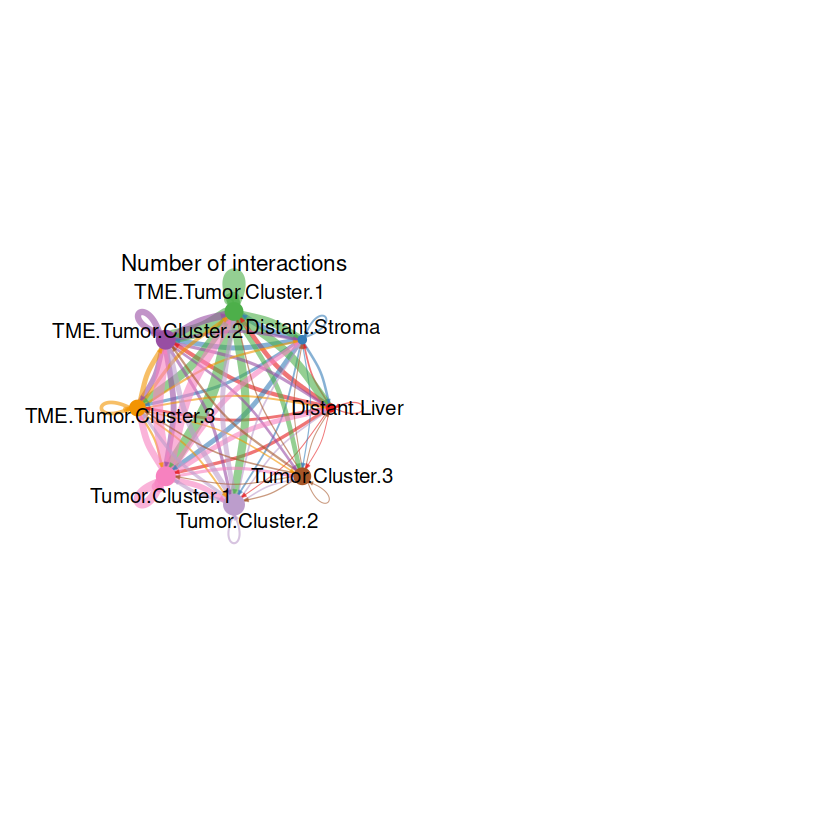

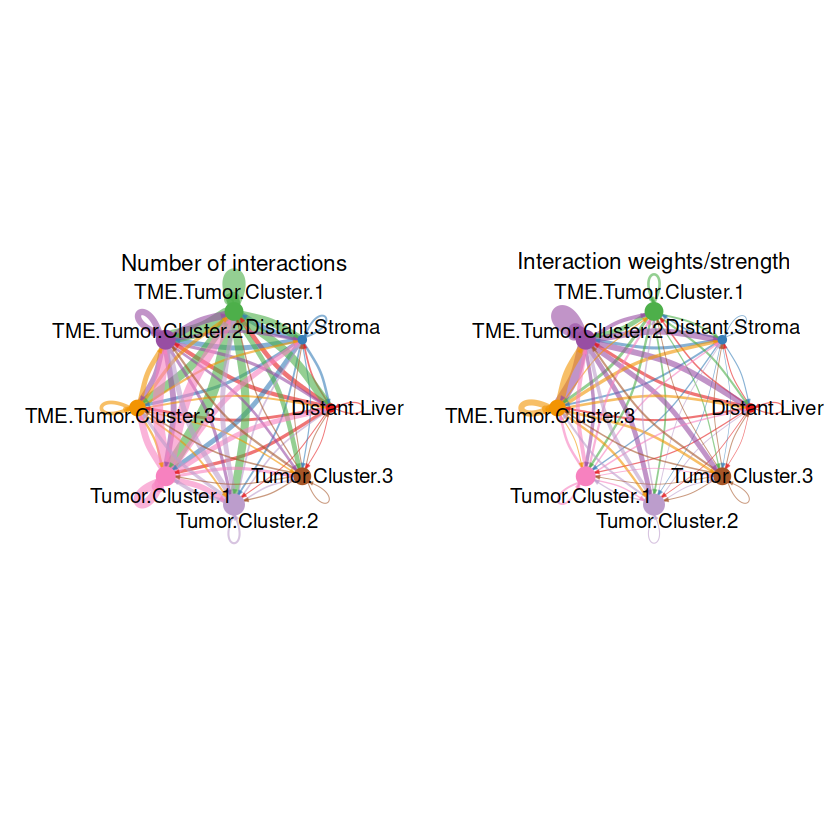

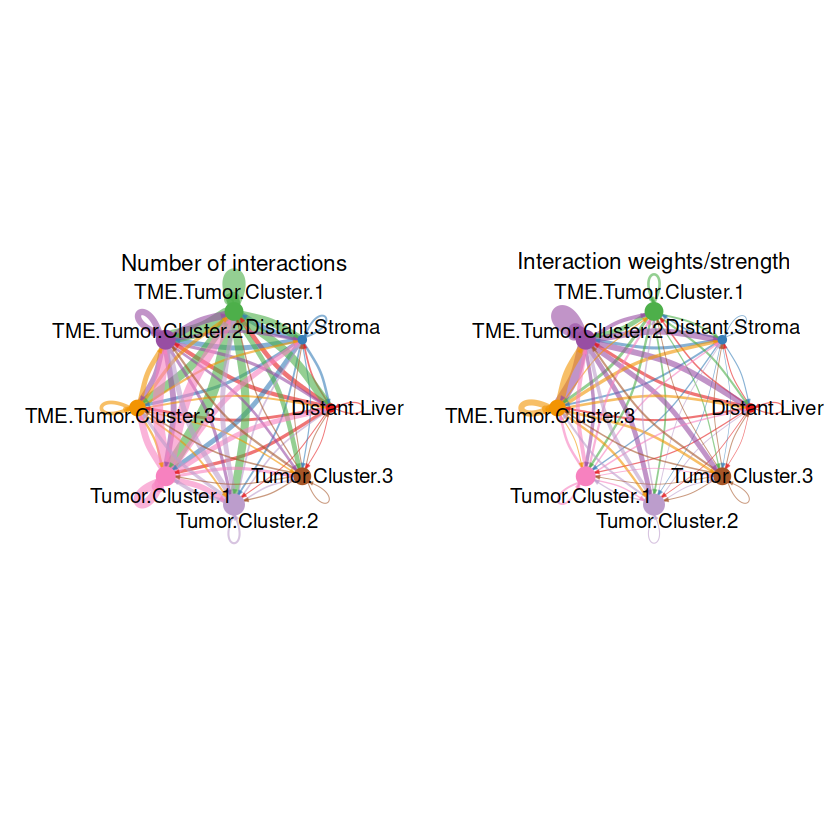

In [110]:
# Step 14. Plot the results
groupSize <- as.numeric(table(cellchat@idents))
head(groupSize)
par(mfrow = c(1,2), xpd=TRUE)
netVisual_circle(cellchat@net$count, vertex.weight = groupSize, weight.scale = T, label.edge= F, title.name = "Number of interactions")
netVisual_circle(cellchat@net$weight, vertex.weight = groupSize, weight.scale = T, label.edge= F, title.name = "Interaction weights/strength")